In [5]:
from BasisFilter import BasisFilter
import pandas as pd
import os
import copy
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [6]:
def standardize_numeric_features(df):
    # 수치형 변수 선택
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
    
    # 0과 1만 존재하는 열은 제외
    non_binary_features = []
    for feature in numeric_features:
        if not set(df[feature].unique()).issubset({0, 1}):
            non_binary_features.append(feature)
    
    # StandardScaler를 사용하여 표준화
    scaler = StandardScaler()
    df[non_binary_features] = scaler.fit_transform(df[non_binary_features])
    
    return df

import numpy as np

# 예시 혼동 행렬

def print_confusion_matrix(cm, class_names):
    """
    혼동 행렬을 콘솔에 보기 좋게 출력하는 함수
    """
    # 혼동 행렬의 행렬을 텍스트로 변환
    print("Confusion Matrix:")
    print(" " * 12, end="")
    for name in class_names:
        print(f"{name:>8}", end=" ")
    print()
    
    for i, row in enumerate(cm):
        print(f"{class_names[i]:<12}", end=" ")
        for value in row:
            print(f"{value:>8}", end=" ")
        print()

# 클래스 이름 지정
class_names = ['Class 0', 'Class 1']



In [3]:
BF = BasisFilter()
df = pd.read_excel(f'{BF.path}//filtered_data//딥러닝 모델 데이터셋.xlsx')

In [4]:
df= standardize_numeric_features(df)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

def feature_selection_with_pytorch(X_train, y_train, num_features):
    input_dim = X_train.shape[1]
    model = LogisticRegressionModel(input_dim).cuda()
    
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).cuda()
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).cuda()
    
    # 모델 학습
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    # 특성 중요도 계산 (가중치 절대값)
    feature_importances = model.linear.weight.data.abs().cpu().numpy().flatten()
    
    # 중요도 기준으로 특성 선택
    selected_indices = feature_importances.argsort()[-num_features:][::-1]
    selected_features = X_train.columns[selected_indices]
    
    return selected_features

def evaluate_feature_selection(X, y, test_size=0.3, random_state=42):
    # 데이터셋 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # 특성 개수에 따른 평가지표 저장 리스트
    num_features_list = list(range(1, 6))
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = {}
    
    for num_features in num_features_list:
        # PyTorch를 사용하여 특성 선택
        selected_features = feature_selection_with_pytorch(X_train, y_train, num_features)
        
        # 선택된 특성을 사용하여 모델 학습 및 평가
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        X_train_tensor = torch.tensor(X_train_selected.values, dtype=torch.float32).cuda()
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).cuda()
        X_test_tensor = torch.tensor(X_test_selected.values, dtype=torch.float32).cuda()
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).cuda()
        
        input_dim = X_train_selected.shape[1]
        model = LogisticRegressionModel(input_dim).cuda()
        
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # 모델 학습
        num_epochs = 10000
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
        
        # 모델 평가
        model.eval()
        with torch.no_grad():
            y_pred_prob = model(X_test_tensor)
            y_pred = (y_pred_prob >= 0.5).float()
        
        accuracy = accuracy_score(y_test_tensor.cpu(), y_pred.cpu())
        f1 = f1_score(y_test_tensor.cpu(), y_pred.cpu(), average='weighted')
        
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        
        # 혼동행렬 계산 및 저장
        conf_matrix = confusion_matrix(y_test_tensor.cpu(), y_pred.cpu())
        confusion_matrices[num_features] = conf_matrix
        
        # 선택된 특성 출력 및 로지스틱 회귀식 출력
        weights = model.linear.weight.data.cpu().numpy().flatten()
        bias = model.linear.bias.data.cpu().numpy()[0]
        
        logistic_equation = " + ".join([f"{w:.4f}*{f}" for w, f in zip(weights, selected_features)])
        logistic_equation += f" + {bias:.4f}"
        
        print(f"Number of features: {num_features}, Selected Features: {selected_features.tolist()}, Accuracy: {accuracy}, F1 Score: {f1}")
        print(f"Logistic Regression Equation: {logistic_equation}")
        print(f"Confusion Matrix:\n{conf_matrix}\n")
    
    # 결과 시각화
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(num_features_list, accuracy_scores, marker='o')
    plt.title('Accuracy vs. Number of Selected Features')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Accuracy')
    plt.xticks(num_features_list)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(num_features_list, f1_scores, marker='o', color='red')
    plt.title('F1 Score vs. Number of Selected Features')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('F1 Score')
    plt.xticks(num_features_list)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    return confusion_matrices

def evaluate_feature_importance_and_set(X, Y):
    for y_col in Y.columns[1:]:
        print(f'Symptom type: {y_col}')
        y = Y[y_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)        
        
        confusion_matrices = evaluate_feature_selection(X, y, test_size=0.2, random_state=42)
        print(f"Confusion Matrices for symptom type {y_col}:\n", confusion_matrices)


Symptom type: Sleepless
Number of features: 1, Selected Features: ['Coffee_없음'], Accuracy: 0.755795434436383, F1 Score: 0.6506757307957654
Logistic Regression Equation: -0.4780*Coffee_없음 + -0.8081
Confusion Matrix:
[[4271    0]
 [1380    0]]

Number of features: 2, Selected Features: ['Coffee_없음', 'EProtein'], Accuracy: 0.755795434436383, F1 Score: 0.6506757307957654
Logistic Regression Equation: -0.4811*Coffee_없음 + -0.3101*EProtein + -0.5261
Confusion Matrix:
[[4271    0]
 [1380    0]]

Number of features: 3, Selected Features: ['Coffee_없음', 'EBodyWater', 'EMineral'], Accuracy: 0.755795434436383, F1 Score: 0.6506757307957654
Logistic Regression Equation: -0.4713*Coffee_없음 + 0.0127*EBodyWater + -0.3071*EMineral + -0.5233
Confusion Matrix:
[[4271    0]
 [1380    0]]

Number of features: 4, Selected Features: ['EMineral', 'Coffee_없음', 'EProtein', 'EBodyWater'], Accuracy: 0.755795434436383, F1 Score: 0.6506757307957654
Logistic Regression Equation: -0.1540*EMineral + -0.4568*Coffee_없음 + -

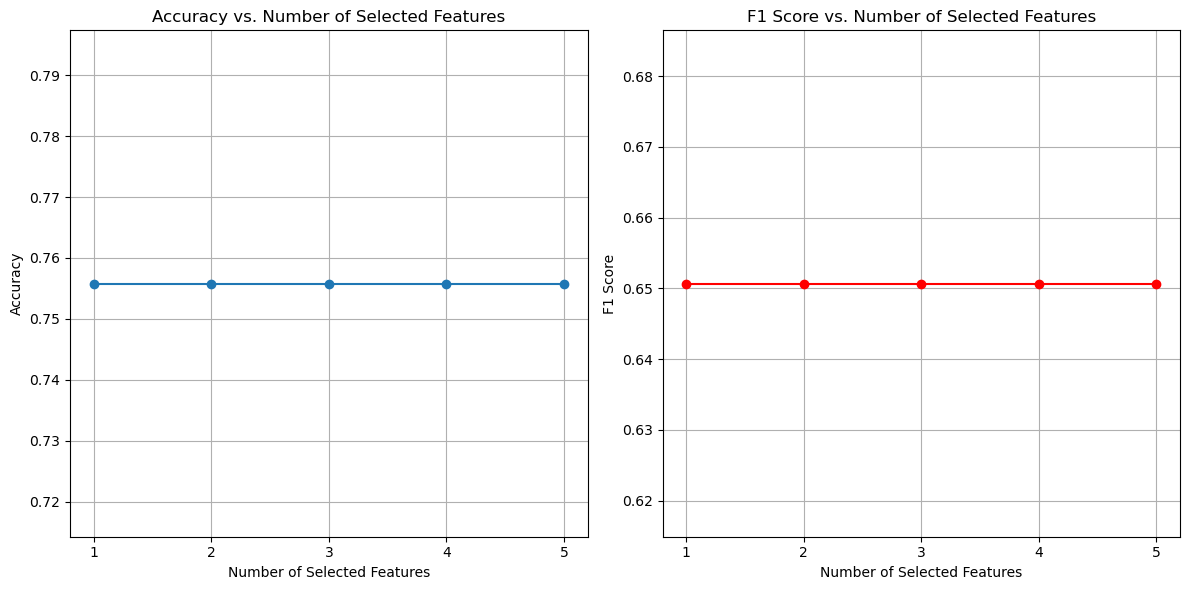

Confusion Matrices for symptom type Sleepless:
 {1: array([[4271,    0],
       [1380,    0]], dtype=int64), 2: array([[4271,    0],
       [1380,    0]], dtype=int64), 3: array([[4271,    0],
       [1380,    0]], dtype=int64), 4: array([[4271,    0],
       [1380,    0]], dtype=int64), 5: array([[4271,    0],
       [1380,    0]], dtype=int64)}
Symptom type: Headache


KeyboardInterrupt: 

In [33]:
X = df.iloc[:,:-11]
Y = df.iloc[:,-11:]
 
evaluate_feature_importance_and_set(X, Y)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

class RandomForestModel:
    def __init__(self, n_estimators=100):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def feature_importances(self):
        return self.model.feature_importances_

def feature_selection_with_random_forest(X_train, y_train, num_features):
    rf_model = RandomForestModel(n_estimators=100)
    rf_model.fit(X_train, y_train)
    
    importances = rf_model.feature_importances()
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    selected_features = feature_importance_df.head(num_features)['Feature'].values
    return selected_features

def evaluate_feature_selection(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    num_features_list = list(range(1, 11))
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = {}
    
    for num_features in num_features_list:
        selected_features = feature_selection_with_random_forest(X_train, y_train, num_features)
        
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train_selected, y_train)
        y_pred = model_rf.predict(X_test_selected)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        confusion_matrices[num_features] = conf_matrix
        
        print(f"Number of features: {num_features}, Selected Features: {selected_features.tolist()}, Accuracy: {accuracy}, F1 Score: {f1}")
        print(f"Confusion Matrix:\n{conf_matrix}\n")
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(num_features_list, accuracy_scores, marker='o')
    plt.title('Accuracy vs. Number of Selected Features')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Accuracy')
    plt.xticks(num_features_list)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(num_features_list, f1_scores, marker='o', color='red')
    plt.title('F1 Score vs. Number of Selected Features')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('F1 Score')
    plt.xticks(num_features_list)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    return confusion_matrices

def evaluate_feature_importance_and_set(X, Y):
    for y_col in Y.columns[1:]:
        print(f'Symptom type: {y_col}')
        y = Y[y_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Random Forest 모델을 사용하여 특성 중요도 평가
        importances = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train).feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print("Feature Importances:\n", feature_importance_df)
        
        top_features = feature_importance_df.head(100)['Feature'].values
        X_filtered = X[top_features]
        
        confusion_matrices = evaluate_feature_selection(X_filtered, y, test_size=0.2, random_state=42)
        print(f"Confusion Matrices for symptom type {y_col}:\n", confusion_matrices)

# 예시 데이터 로드 (사용자 데이터로 교체 필요)
# X = pd.DataFrame(...) 
# Y = pd.DataFrame(...) 
# evaluate_feature_importance_and_set(X, Y)


Symptom type: Sleepless
Feature Importances:
            Feature  Importance
30             Age    0.012754
118          Pulse    0.012129
90        MaxVital    0.011543
96        MinVital    0.010952
9             1_TR    0.010082
..             ...         ...
180  neck_MuscleDF    0.000000
179    neck_Muscle    0.000000
178     neck_FatST    0.000000
177       neck_Fat    0.000000
103        PHeight    0.000000

[194 rows x 2 columns]
Number of features: 1, Selected Features: ['Age'], Accuracy: 0.755795434436383, F1 Score: 0.6506757307957654
Confusion Matrix:
[[4271    0]
 [1380    0]]

Number of features: 2, Selected Features: ['Age', 'Pulse'], Accuracy: 0.7274818616174128, F1 Score: 0.651486744916695
Confusion Matrix:
[[4056  215]
 [1325   55]]

Number of features: 3, Selected Features: ['Age', 'Pulse', 'MaxVital'], Accuracy: 0.7009378870996283, F1 Score: 0.6596175524284621
Confusion Matrix:
[[3787  484]
 [1206  174]]

Number of features: 4, Selected Features: ['Age', 'Pulse', 'Ma

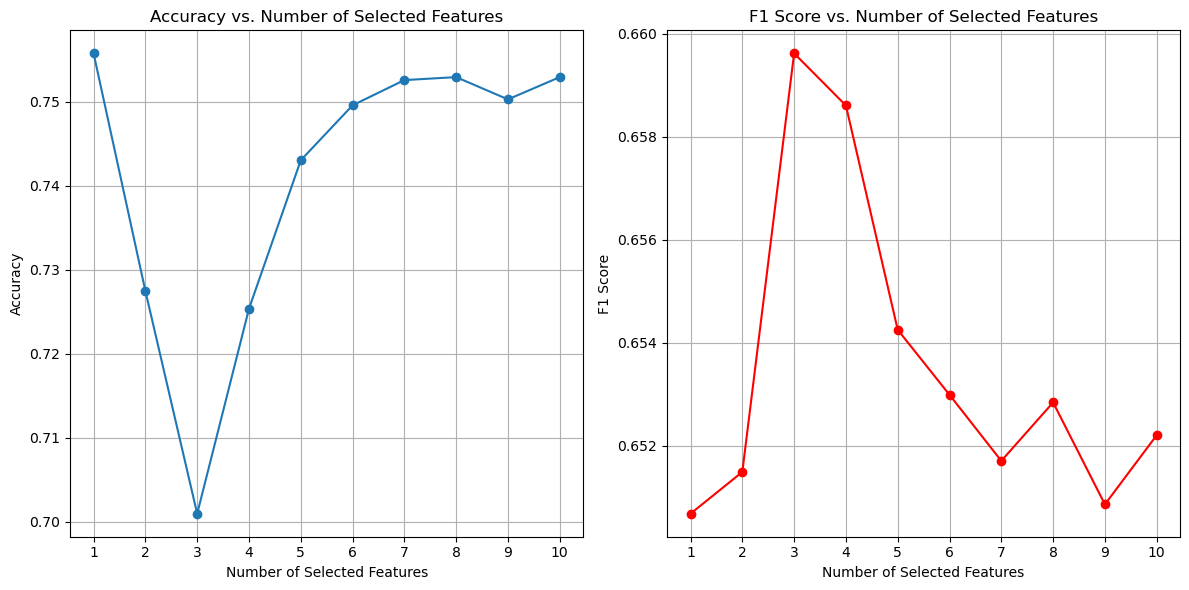

Confusion Matrices for symptom type Sleepless:
 {1: array([[4271,    0],
       [1380,    0]], dtype=int64), 2: array([[4056,  215],
       [1325,   55]], dtype=int64), 3: array([[3787,  484],
       [1206,  174]], dtype=int64), 4: array([[4009,  262],
       [1290,   90]], dtype=int64), 5: array([[4166,  105],
       [1347,   33]], dtype=int64), 6: array([[4219,   52],
       [1363,   17]], dtype=int64), 7: array([[4245,   26],
       [1372,    8]], dtype=int64), 8: array([[4244,   27],
       [1369,   11]], dtype=int64), 9: array([[4231,   40],
       [1371,    9]], dtype=int64), 10: array([[4246,   25],
       [1371,    9]], dtype=int64)}
Symptom type: Headache
Feature Importances:
           Feature  Importance
30            Age    0.012424
118         Pulse    0.012084
90       MaxVital    0.011455
96       MinVital    0.011284
7            1_RA    0.010359
..            ...         ...
172  hip_MuscleDF    0.000000
171    hip_Muscle    0.000000
170     hip_FatST    0.000000
169  

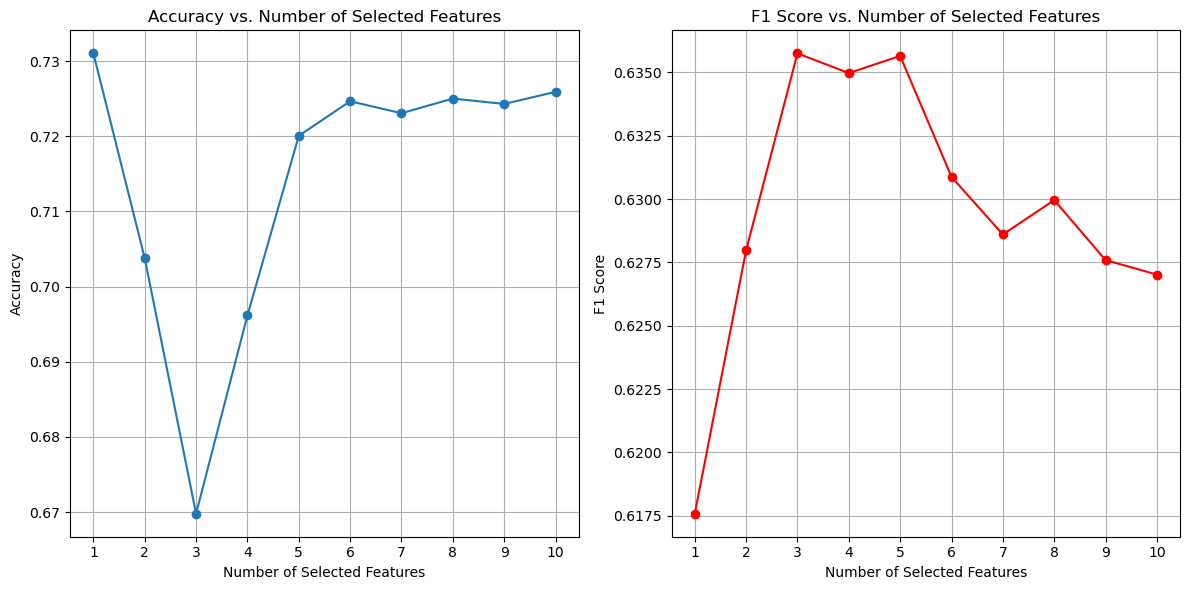

Confusion Matrices for symptom type Headache:
 {1: array([[4131,    1],
       [1519,    0]], dtype=int64), 2: array([[3886,  246],
       [1428,   91]], dtype=int64), 3: array([[3532,  600],
       [1266,  253]], dtype=int64), 4: array([[3789,  343],
       [1374,  145]], dtype=int64), 5: array([[3986,  146],
       [1436,   83]], dtype=int64), 6: array([[4040,   92],
       [1464,   55]], dtype=int64), 7: array([[4036,   96],
       [1469,   50]], dtype=int64), 8: array([[4046,   86],
       [1468,   51]], dtype=int64), 9: array([[4049,   83],
       [1475,   44]], dtype=int64), 10: array([[4063,   69],
       [1480,   39]], dtype=int64)}
Symptom type: Brash
Feature Importances:
           Feature  Importance
118         Pulse    0.012488
96       MinVital    0.012482
90       MaxVital    0.011693
30            Age    0.010840
4         1000_TR    0.010609
..            ...         ...
179   neck_Muscle    0.000000
178    neck_FatST    0.000000
177      neck_Fat    0.000000
171    hi

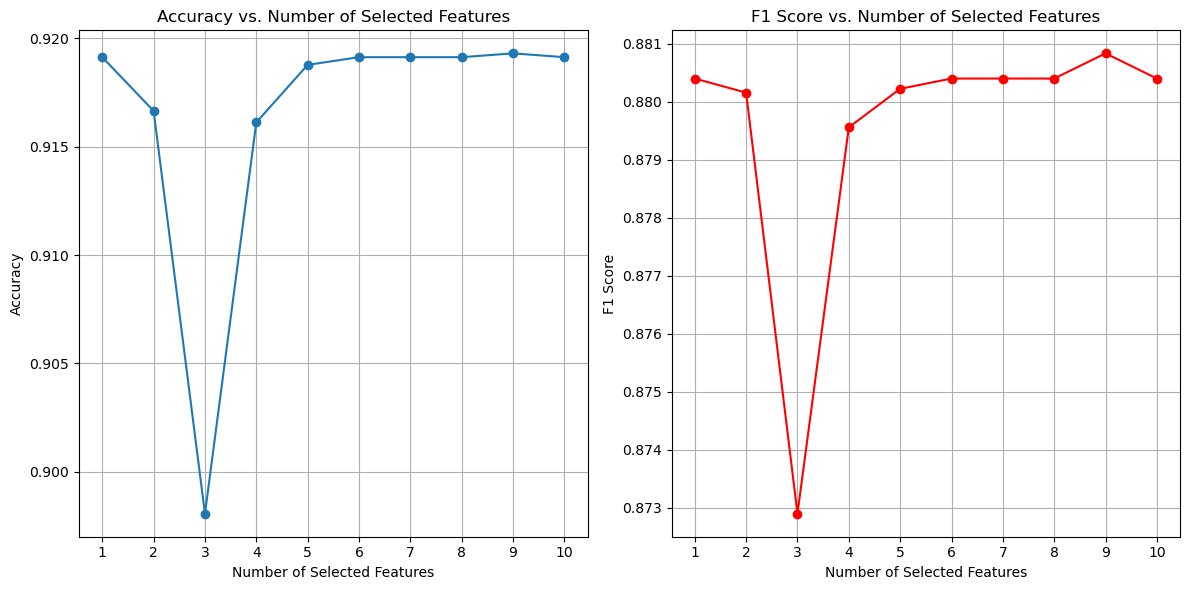

Confusion Matrices for symptom type Brash:
 {1: array([[5194,    0],
       [ 457,    0]], dtype=int64), 2: array([[5177,   17],
       [ 454,    3]], dtype=int64), 3: array([[5063,  131],
       [ 445,   12]], dtype=int64), 4: array([[5175,   19],
       [ 455,    2]], dtype=int64), 5: array([[5192,    2],
       [ 457,    0]], dtype=int64), 6: array([[5194,    0],
       [ 457,    0]], dtype=int64), 7: array([[5194,    0],
       [ 457,    0]], dtype=int64), 8: array([[5194,    0],
       [ 457,    0]], dtype=int64), 9: array([[5194,    0],
       [ 456,    1]], dtype=int64), 10: array([[5194,    0],
       [ 457,    0]], dtype=int64)}
Symptom type: Constipation
Feature Importances:
           Feature  Importance
30            Age    0.014430
118         Pulse    0.013298
90       MaxVital    0.012275
96       MinVital    0.011844
9            1_TR    0.010381
..            ...         ...
172  hip_MuscleDF    0.000000
171    hip_Muscle    0.000000
170     hip_FatST    0.000000
169  

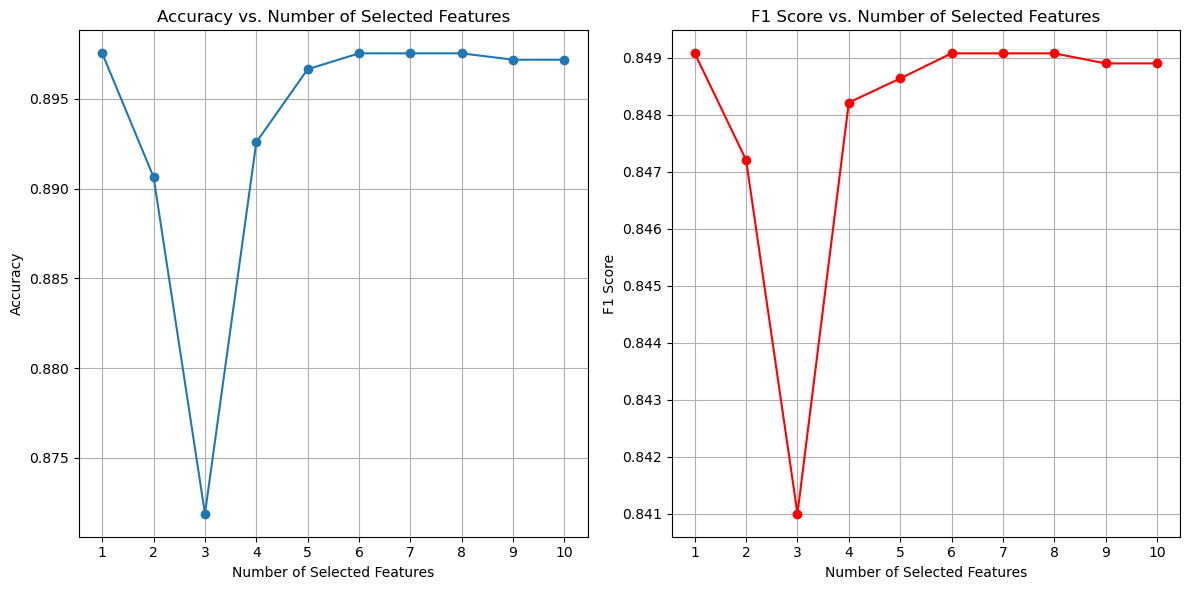

Confusion Matrices for symptom type Constipation:
 {1: array([[5072,    0],
       [ 579,    0]], dtype=int64), 2: array([[5028,   44],
       [ 574,    5]], dtype=int64), 3: array([[4908,  164],
       [ 560,   19]], dtype=int64), 4: array([[5039,   33],
       [ 574,    5]], dtype=int64), 5: array([[5067,    5],
       [ 579,    0]], dtype=int64), 6: array([[5072,    0],
       [ 579,    0]], dtype=int64), 7: array([[5072,    0],
       [ 579,    0]], dtype=int64), 8: array([[5072,    0],
       [ 579,    0]], dtype=int64), 9: array([[5070,    2],
       [ 579,    0]], dtype=int64), 10: array([[5070,    2],
       [ 579,    0]], dtype=int64)}
Symptom type: Depression
Feature Importances:
            Feature  Importance
90        MaxVital    0.012413
96        MinVital    0.012352
118          Pulse    0.011742
19          500_TR    0.010357
27            5_RA    0.010175
..             ...         ...
103        PHeight    0.000000
98        MonthAge    0.000000
126  Rarm_MuscleST   

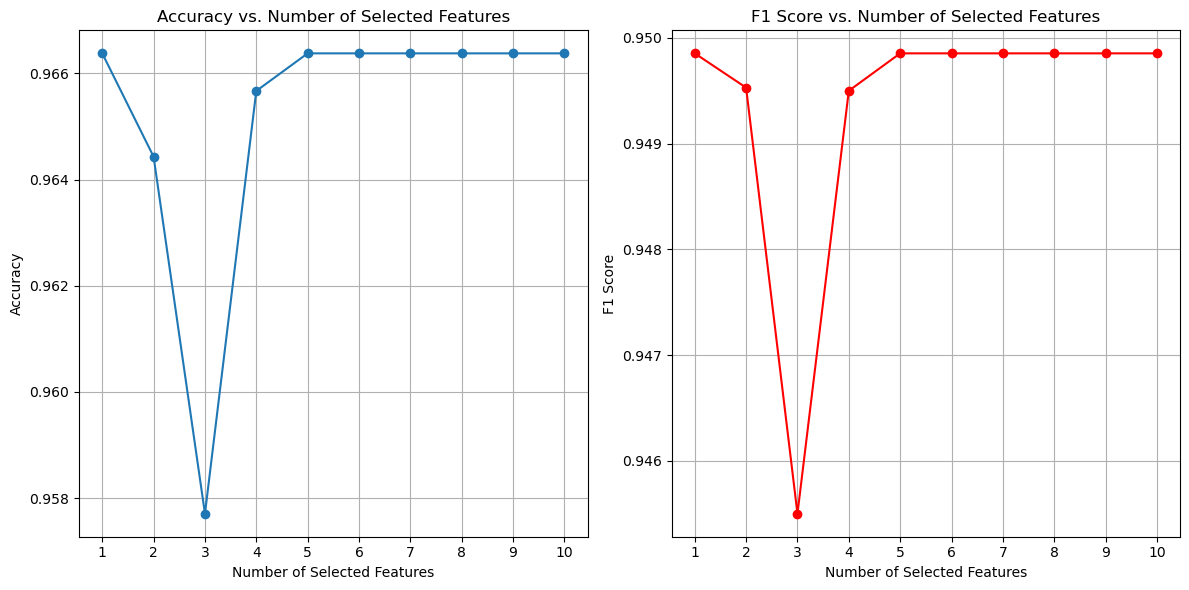

Confusion Matrices for symptom type Depression:
 {1: array([[5461,    0],
       [ 190,    0]], dtype=int64), 2: array([[5448,   13],
       [ 188,    2]], dtype=int64), 3: array([[5412,   49],
       [ 190,    0]], dtype=int64), 4: array([[5457,    4],
       [ 190,    0]], dtype=int64), 5: array([[5461,    0],
       [ 190,    0]], dtype=int64), 6: array([[5461,    0],
       [ 190,    0]], dtype=int64), 7: array([[5461,    0],
       [ 190,    0]], dtype=int64), 8: array([[5461,    0],
       [ 190,    0]], dtype=int64), 9: array([[5461,    0],
       [ 190,    0]], dtype=int64), 10: array([[5461,    0],
       [ 190,    0]], dtype=int64)}
Symptom type: Metrorrhagia
Feature Importances:
           Feature  Importance
96       MinVital    0.011846
90       MaxVital    0.011671
118         Pulse    0.010994
26           5_LL    0.010558
12         250_RA    0.010342
..            ...         ...
172  hip_MuscleDF    0.000000
171    hip_Muscle    0.000000
170     hip_FatST    0.000000


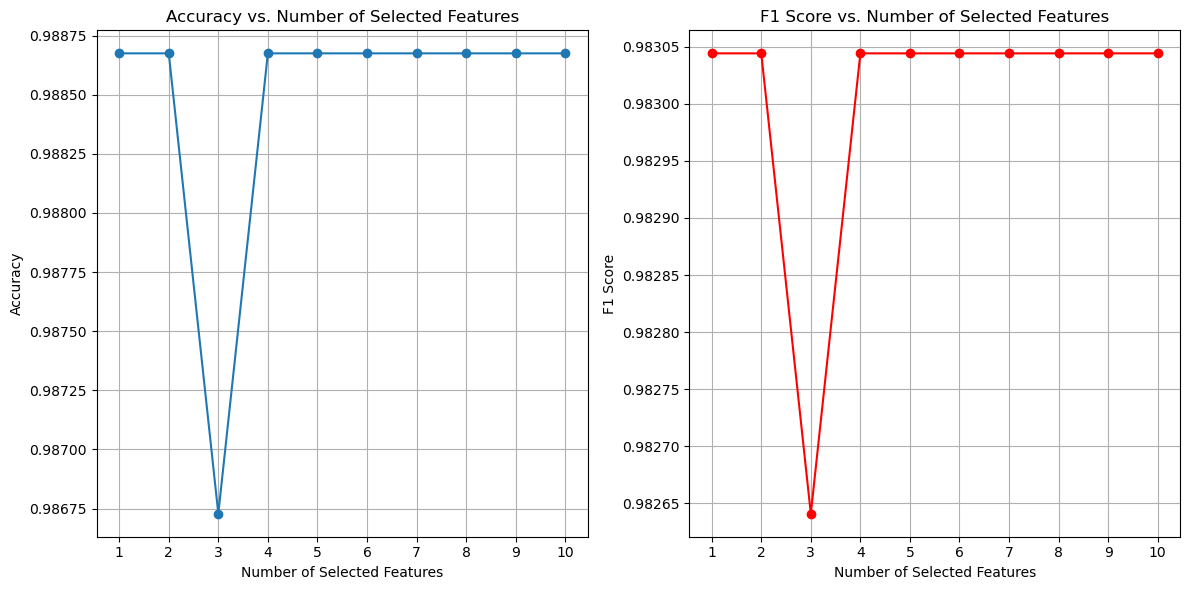

Confusion Matrices for symptom type Metrorrhagia:
 {1: array([[5587,    0],
       [  64,    0]], dtype=int64), 2: array([[5587,    0],
       [  64,    0]], dtype=int64), 3: array([[5574,   13],
       [  62,    2]], dtype=int64), 4: array([[5587,    0],
       [  64,    0]], dtype=int64), 5: array([[5587,    0],
       [  64,    0]], dtype=int64), 6: array([[5587,    0],
       [  64,    0]], dtype=int64), 7: array([[5587,    0],
       [  64,    0]], dtype=int64), 8: array([[5587,    0],
       [  64,    0]], dtype=int64), 9: array([[5587,    0],
       [  64,    0]], dtype=int64), 10: array([[5587,    0],
       [  64,    0]], dtype=int64)}
Symptom type: Urination
Feature Importances:
            Feature  Importance
30             Age    0.014152
90        MaxVital    0.012027
118          Pulse    0.011901
96        MinVital    0.011849
4          1000_TR    0.010427
..             ...         ...
178     neck_FatST    0.000000
181  neck_MuscleST    0.000000
180  neck_MuscleDF    

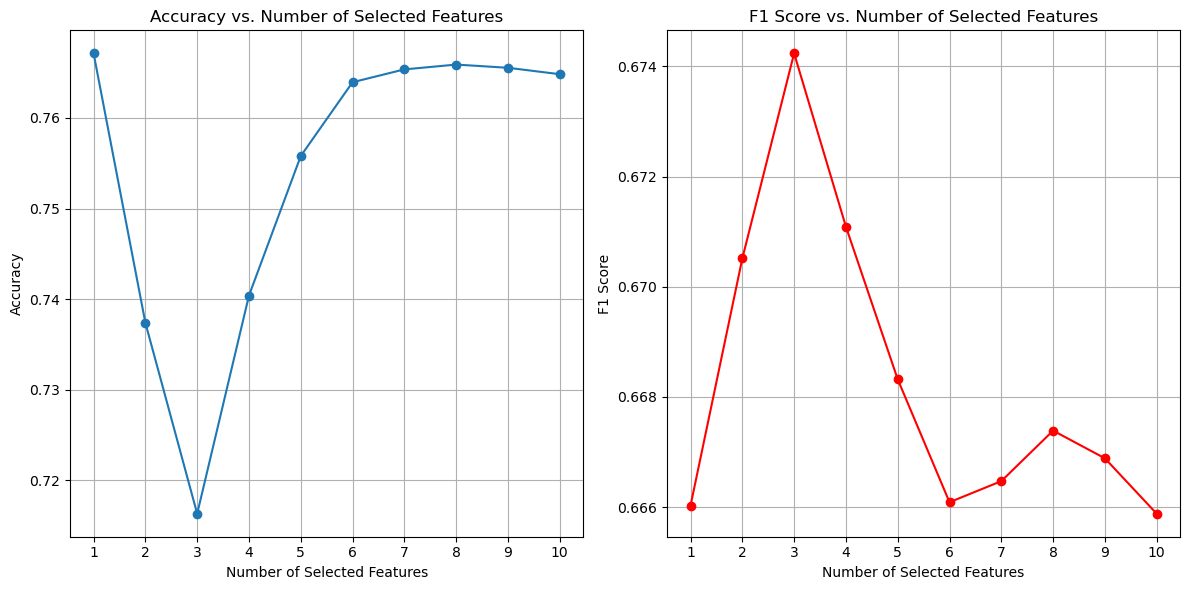

Confusion Matrices for symptom type Urination:
 {1: array([[4335,    0],
       [1316,    0]], dtype=int64), 2: array([[4093,  242],
       [1242,   74]], dtype=int64), 3: array([[3891,  444],
       [1159,  157]], dtype=int64), 4: array([[4115,  220],
       [1247,   69]], dtype=int64), 5: array([[4245,   90],
       [1290,   26]], dtype=int64), 6: array([[4312,   23],
       [1311,    5]], dtype=int64), 7: array([[4321,   14],
       [1312,    4]], dtype=int64), 8: array([[4322,   13],
       [1310,    6]], dtype=int64), 9: array([[4321,   14],
       [1311,    5]], dtype=int64), 10: array([[4319,   16],
       [1313,    3]], dtype=int64)}
Symptom type: Numbness
Feature Importances:
              Feature  Importance
90          MaxVital    0.012889
96          MinVital    0.012139
118            Pulse    0.011867
28              5_RL    0.010854
27              5_RA    0.010838
..               ...         ...
170        hip_FatST    0.000000
169          hip_Fat    0.000000
168     

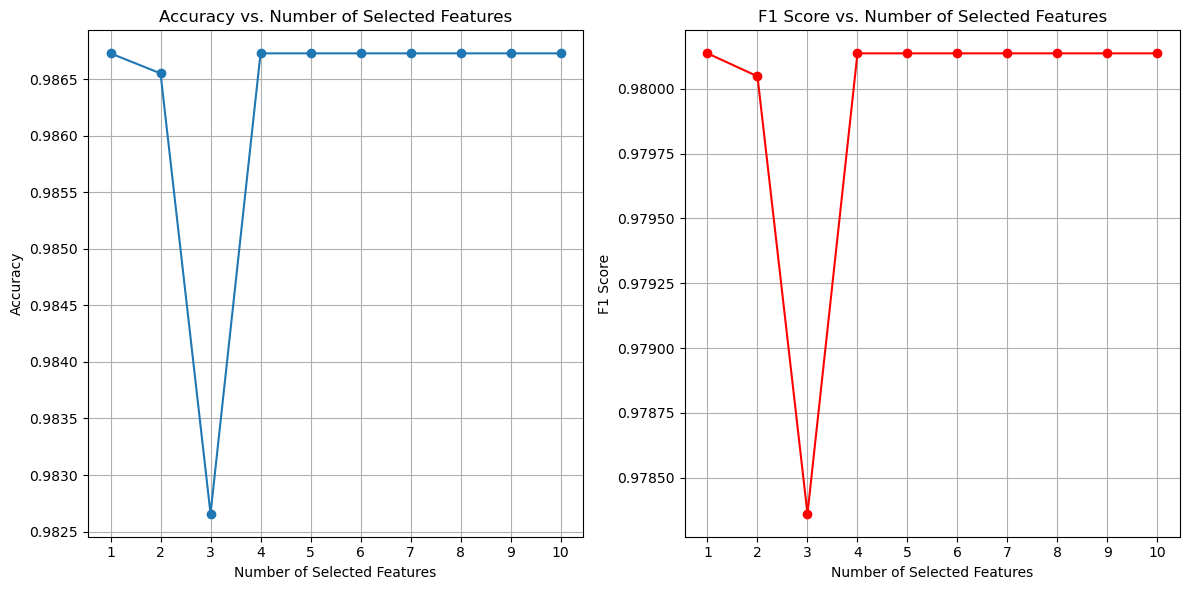

Confusion Matrices for symptom type Numbness:
 {1: array([[5576,    0],
       [  75,    0]], dtype=int64), 2: array([[5575,    1],
       [  75,    0]], dtype=int64), 3: array([[5552,   24],
       [  74,    1]], dtype=int64), 4: array([[5576,    0],
       [  75,    0]], dtype=int64), 5: array([[5576,    0],
       [  75,    0]], dtype=int64), 6: array([[5576,    0],
       [  75,    0]], dtype=int64), 7: array([[5576,    0],
       [  75,    0]], dtype=int64), 8: array([[5576,    0],
       [  75,    0]], dtype=int64), 9: array([[5576,    0],
       [  75,    0]], dtype=int64), 10: array([[5576,    0],
       [  75,    0]], dtype=int64)}
Symptom type: Sweet
Feature Importances:
           Feature  Importance
118         Pulse    0.013037
90       MaxVital    0.012496
96       MinVital    0.012171
30            Age    0.011324
29           5_TR    0.010885
..            ...         ...
173  hip_MuscleST    0.000000
172  hip_MuscleDF    0.000000
170     hip_FatST    0.000000
169      

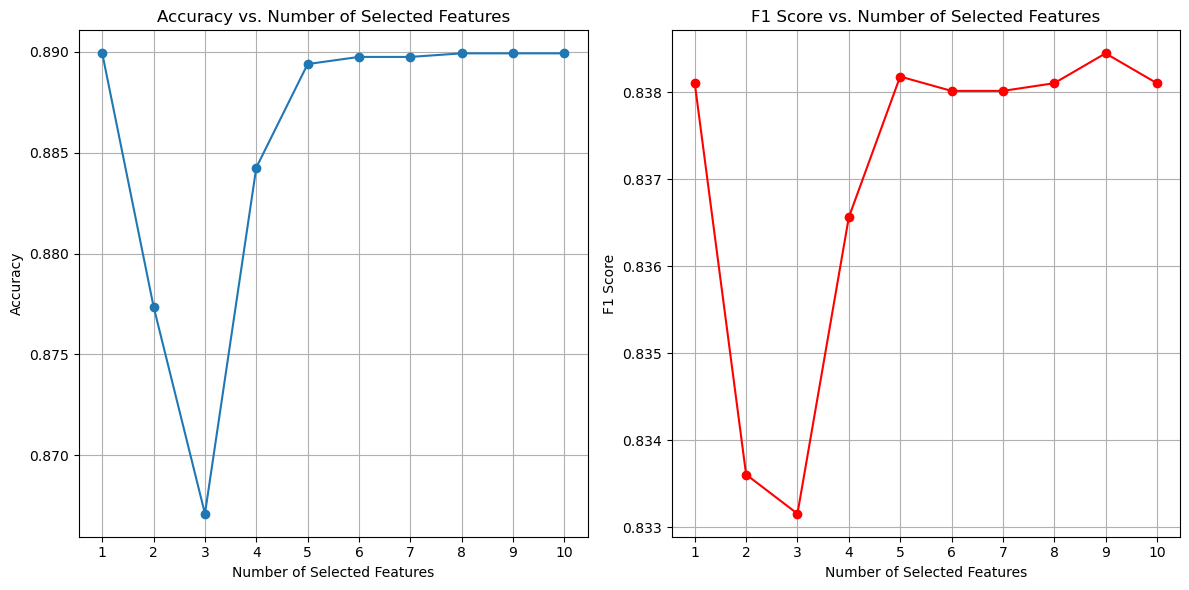

Confusion Matrices for symptom type Sweet:
 {1: array([[5029,    0],
       [ 622,    0]], dtype=int64), 2: array([[4952,   77],
       [ 616,    6]], dtype=int64), 3: array([[4875,  154],
       [ 597,   25]], dtype=int64), 4: array([[4993,   36],
       [ 618,    4]], dtype=int64), 5: array([[5025,    4],
       [ 621,    1]], dtype=int64), 6: array([[5028,    1],
       [ 622,    0]], dtype=int64), 7: array([[5028,    1],
       [ 622,    0]], dtype=int64), 8: array([[5029,    0],
       [ 622,    0]], dtype=int64), 9: array([[5028,    1],
       [ 621,    1]], dtype=int64), 10: array([[5029,    0],
       [ 622,    0]], dtype=int64)}
Symptom type: Hair
Feature Importances:
            Feature  Importance
30             Age    0.013901
29            5_TR    0.012462
10          250_LA    0.012364
118          Pulse    0.012284
146            VFA    0.012071
..             ...         ...
81      Lleg_FatST    0.000000
123     Rarm_FatST    0.000000
121  Rarm_CircumST    0.000000
98 

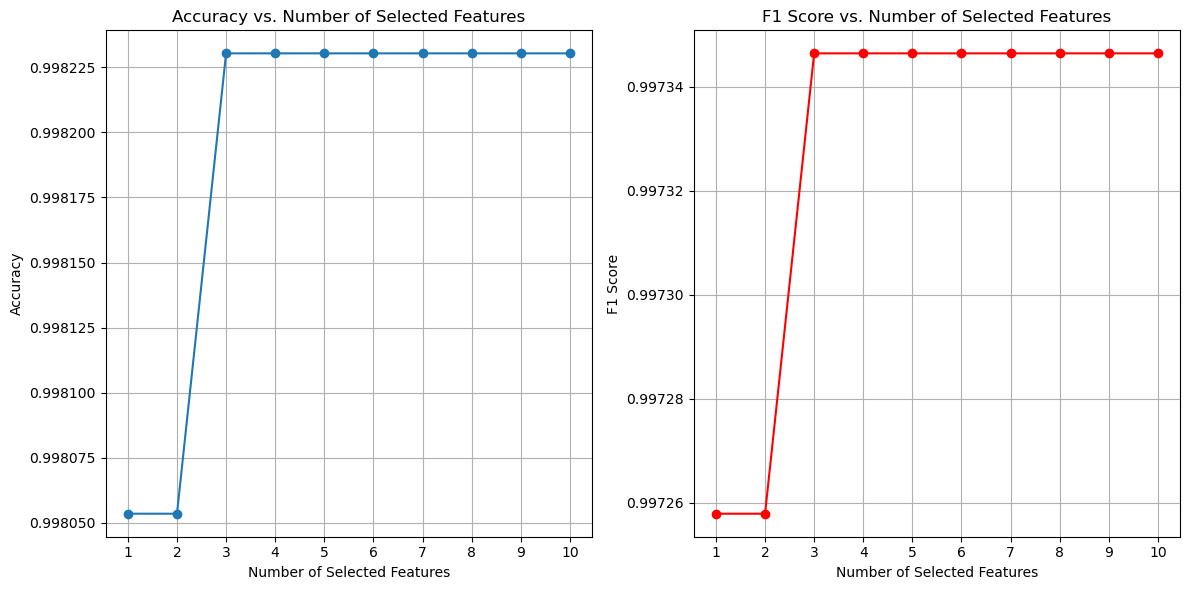

Confusion Matrices for symptom type Hair:
 {1: array([[5640,    1],
       [  10,    0]], dtype=int64), 2: array([[5640,    1],
       [  10,    0]], dtype=int64), 3: array([[5641,    0],
       [  10,    0]], dtype=int64), 4: array([[5641,    0],
       [  10,    0]], dtype=int64), 5: array([[5641,    0],
       [  10,    0]], dtype=int64), 6: array([[5641,    0],
       [  10,    0]], dtype=int64), 7: array([[5641,    0],
       [  10,    0]], dtype=int64), 8: array([[5641,    0],
       [  10,    0]], dtype=int64), 9: array([[5641,    0],
       [  10,    0]], dtype=int64), 10: array([[5641,    0],
       [  10,    0]], dtype=int64)}


In [23]:
# 예시 데이터 로드 (사용자 데이터로 교체 필요)
X = df.iloc[:,:-11]
Y = df.iloc[:,-11:]
 
evaluate_feature_importance_and_set(X, Y)

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

class KNNModel:
    def __init__(self, n_neighbors=5):
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def feature_importances(self):
        # KNN 모델에서는 특성 중요도를 제공하지 않음
        return None

def feature_selection_with_knn(X_train, y_train, num_features):
    # KNN에서는 특성 중요도를 직접적으로 제공하지 않으므로,
    # 단순히 모든 특성을 사용하고 이후 평가할 수 있음
    # KNN의 경우, 특성 선택 과정에서 별도의 중요도 기반 방법이 필요하지 않음
    return X_train.columns[:num_features]

def evaluate_feature_selection(X, y, y_col, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    num_features_list = list(range(1, min(X_train.shape[1], 50) + 1))
    accuracy_scores = []
    f1_scores = []
    auc_scores = []
    recall_scores = []
    confusion_matrices = {}
    
    best_accuracy = -np.inf
    best_f1 = -np.inf
    best_auc = -np.inf
    best_recall = -np.inf
    
    best_accuracy_num_features = 0
    best_f1_num_features = 0
    best_auc_num_features = 0
    best_recall_num_features = 0
    
    best_accuracy_conf_matrix = None
    best_f1_conf_matrix = None
    best_auc_conf_matrix = None
    best_recall_conf_matrix = None
    
    for num_features in num_features_list:
        selected_features = feature_selection_with_knn(X_train, y_train, num_features)
        
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        model_knn = KNNModel(n_neighbors=5)
        model_knn.fit(X_train_selected, y_train)
        y_pred = model_knn.predict(X_test_selected)
        y_prob = model_knn.model.predict_proba(X_test_selected)[:, 1]  # KNN 모델의 확률 예측
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_prob)
        recall = recall_score(y_test, y_pred, average='weighted')
        
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        auc_scores.append(auc)
        recall_scores.append(recall)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        confusion_matrices[num_features] = conf_matrix
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_accuracy_num_features = num_features
            best_accuracy_conf_matrix = conf_matrix
            best_accuracy_features = selected_features
        
        if f1 > best_f1:
            best_f1 = f1
            best_f1_num_features = num_features
            best_f1_conf_matrix = conf_matrix
            best_f1_features = selected_features
        
        if auc > best_auc:
            best_auc = auc
            best_auc_num_features = num_features
            best_auc_conf_matrix = conf_matrix
            best_auc_features = selected_features
        
    
    
    # 플롯 설정
    plt.figure(figsize=(16, 12))
    
    # 각 성능 지표에 대한 플롯
    plt.plot(num_features_list, accuracy_scores, marker='o', label='Accuracy')
    plt.plot(num_features_list, f1_scores, marker='o', color='red', label='F1 Score')
    plt.plot(num_features_list, auc_scores, marker='o', color='green', label='AUC')
    
    # 제목 및 레이블 설정
    plt.title('The Number of Feature ~ KNN Model Value Index')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.xticks(num_features_list)
    plt.grid()
    plt.legend()
    
    # 플롯을 파일로 저장
    plt.savefig(f'{BF.path}\\불편증상 분류모델\\{y_col}_knn_evaluation_metrics.png')
    
    # 플롯 보여주기
    plt.show()

    print(f"Best number of features for Accuracy: {best_accuracy_num_features}, Accuracy: {best_accuracy}")
    print(f"Selected Features:{best_accuracy_features}\n")
    print(f"Confusion Matrix:\n{best_accuracy_conf_matrix}\n")
    
    print(f"Best number of features for F1 Score: {best_f1_num_features}, F1 Score: {best_f1}")
    print(f"Selected Features:{best_f1_features}\n")
    print(f"Confusion Matrix:\n{best_f1_conf_matrix}\n")
    
    print(f"Best number of features for AUC: {best_auc_num_features}, AUC: {best_auc}")
    print(f"Selected Features:{best_auc_features}\n")
    print(f"Confusion Matrix:\n{best_auc_conf_matrix}\n")
    
    
    return confusion_matrices

def evaluate_feature_importance_and_set(X, Y):
    for y_col in Y.columns[1:]:
        print(f'Symptom type: {y_col}')
        y = Y[y_col]
        
        confusion_matrices = evaluate_feature_selection(X, y, y_col, test_size=0.2, random_state=42)
        print(f"Confusion Matrices for symptom type {y_col}:\n", confusion_matrices)


In [95]:
#SMOTE 오버샘플링 + 1~10 모든 조합 시도

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

class KNNModel:
    def __init__(self, n_neighbors=5):
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def feature_importances(self):
        return None

def feature_selection_with_knn(X_train, num_features):
    features_combinations = []
    features = X_train.columns
    for comb in combinations(features, num_features):
        features_combinations.append(list(comb))
    return features_combinations

def evaluate_feature_selection(X, y, y_col, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # SMOTE 적용
    smote = SMOTE(random_state=random_state, sampling_strategy='auto')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    num_features_list = list(range(1, min(X_train_resampled.shape[1], 50) + 1))
    accuracy_scores = []
    f1_scores = []
    auc_scores = []
    recall_scores = []
    confusion_matrices = {}
    
    best_accuracy = -np.inf
    best_f1 = -np.inf
    best_auc = -np.inf
    best_recall = -np.inf
    
    best_accuracy_num_features = 0
    best_f1_num_features = 0
    best_auc_num_features = 0
    best_recall_num_features = 0
    
    best_accuracy_conf_matrix = None
    best_f1_conf_matrix = None
    best_auc_conf_matrix = None
    best_recall_conf_matrix = None
    
    for num_features in num_features_list:
        print(f'num_features: {num_features}')
        features_combinations = feature_selection_with_knn(X_train_resampled, num_features)
        for selected_features in features_combinations:
            X_train_selected = X_train_resampled[selected_features]
            X_test_selected = X_test[selected_features]

            model_knn = KNNModel(n_neighbors=5)
            model_knn.fit(X_train_selected, y_train_resampled)
            y_pred = model_knn.predict(X_test_selected)
            y_prob = model_knn.model.predict_proba(X_test_selected)[:, 1]

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            auc = roc_auc_score(y_test, y_prob)
            recall = recall_score(y_test, y_pred, average='weighted')

            accuracy_scores.append(accuracy)
            f1_scores.append(f1)
            auc_scores.append(auc)
            recall_scores.append(recall)

            conf_matrix = confusion_matrix(y_test, y_pred)
            confusion_matrices[num_features] = conf_matrix

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_accuracy_num_features = num_features
                best_accuracy_conf_matrix = conf_matrix
                best_accuracy_features = selected_features

            if f1 > best_f1:
                best_f1 = f1
                best_f1_num_features = num_features
                best_f1_conf_matrix = conf_matrix
                best_f1_features = selected_features

            if auc > best_auc:
                best_auc = auc
                best_auc_num_features = num_features
                best_auc_conf_matrix = conf_matrix
                best_auc_features = selected_features

    plt.figure(figsize=(16, 12))
    
    plt.plot(num_features_list, accuracy_scores, marker='o', label='Accuracy')
    plt.plot(num_features_list, f1_scores, marker='o', color='red', label='F1 Score')
    plt.plot(num_features_list, auc_scores, marker='o', color='green', label='AUC')
    
    plt.title('The Number of Feature ~ KNN Model Value Index')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.xticks(num_features_list)
    plt.grid()
    plt.legend()
    
    plt.savefig(f'{BF.path}\\불편증상 분류모델\\{y_col}_knn_evaluation_metrics.png')
    
    plt.show()

    print(f"Best number of features for Accuracy: {best_accuracy_num_features}, Accuracy: {best_accuracy}")
    print(f"Selected Features:{best_accuracy_features}\n")
    print(f"Confusion Matrix:\n{best_accuracy_conf_matrix}\n")
    
    print(f"Best number of features for F1 Score: {best_f1_num_features}, F1 Score: {best_f1}")
    print(f"Selected Features:{best_f1_features}\n")
    print(f"Confusion Matrix:\n{best_f1_conf_matrix}\n")
    
    print(f"Best number of features for AUC: {best_auc_num_features}, AUC: {best_auc}")
    print(f"Selected Features:{best_auc_features}\n")
    print(f"Confusion Matrix:\n{best_auc_conf_matrix}\n")
    
    return confusion_matrices

def evaluate_feature_importance_and_set(X, Y):
    for y_col in Y.columns:
        print(f'Symptom type: {y_col}')
        y = Y[y_col]
        
        confusion_matrices = evaluate_feature_selection(X, y, y_col, test_size=0.2, random_state=42)
        print(f"Confusion Matrices for symptom type {y_col}:\n", confusion_matrices)


In [ ]:
# 예시 데이터 로드 (사용자 데이터로 교체 필요)
X = df.iloc[:,:-11]
Y = df.iloc[:,-11:]
Y = Y[['Sleepless','Headache','Urination']]
 
evaluate_feature_importance_and_set(X, Y)

Symptom type: Sleepless
num_features: 1
num_features: 2
num_features: 3



Symptom type: Sleepless

Epoch [10000/100000], Loss: 0.0939, Accuracy: 0.6339, Precision: 0.2639, Recall: 0.2790, F1 Score: 0.2712, AUC: 0.5323
Epoch [20000/100000], Loss: 0.0453, Accuracy: 0.6305, Precision: 0.2621, Recall: 0.2826, F1 Score: 0.2720, AUC: 0.5354
Epoch [30000/100000], Loss: 0.0261, Accuracy: 0.6339, Precision: 0.2680, Recall: 0.2884, F1 Score: 0.2778, AUC: 0.5378
Epoch [40000/100000], Loss: 0.0277, Accuracy: 0.6363, Precision: 0.2709, Recall: 0.2891, F1 Score: 0.2797, AUC: 0.5295
Epoch [50000/100000], Loss: 0.0034, Accuracy: 0.6282, Precision: 0.2605, Recall: 0.2841, F1 Score: 0.2718, AUC: 0.5338
Epoch [60000/100000], Loss: 0.0000, Accuracy: 0.6264, Precision: 0.2600, Recall: 0.2870, F1 Score: 0.2728, AUC: 0.5443
Epoch [70000/100000], Loss: 0.0000, Accuracy: 0.6256, Precision: 0.2582, Recall: 0.2848, F1 Score: 0.2708, AUC: 0.5444
Epoch [80000/100000], Loss: 3.5284, Accuracy: 0.6394, Precision: 0.2750, Recall: 0.2913, F1 Score: 0.2829, AUC: 0.5627
Epoch [90000/100000], 

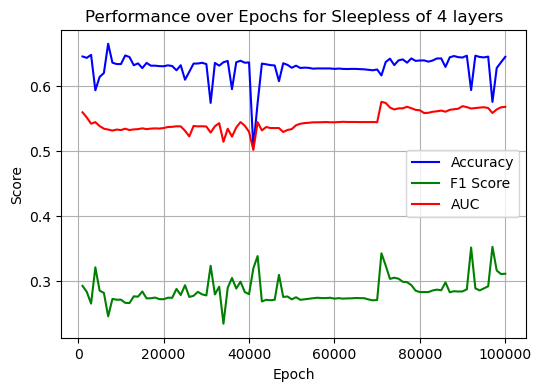

Epoch [10000/100000], Loss: 0.2438, Accuracy: 0.6227, Precision: 0.2851, Recall: 0.3616, F1 Score: 0.3188, AUC: 0.5560
Epoch [20000/100000], Loss: 0.1975, Accuracy: 0.6494, Precision: 0.2772, Recall: 0.2710, F1 Score: 0.2741, AUC: 0.5523
Epoch [30000/100000], Loss: 0.1255, Accuracy: 0.6202, Precision: 0.2760, Recall: 0.3420, F1 Score: 0.3055, AUC: 0.5353
Epoch [40000/100000], Loss: 0.0282, Accuracy: 0.6218, Precision: 0.2682, Recall: 0.3174, F1 Score: 0.2907, AUC: 0.5272
Epoch [50000/100000], Loss: 0.0495, Accuracy: 0.6213, Precision: 0.2762, Recall: 0.3399, F1 Score: 0.3047, AUC: 0.5344
Epoch [60000/100000], Loss: 0.0000, Accuracy: 0.6190, Precision: 0.2701, Recall: 0.3290, F1 Score: 0.2966, AUC: 0.5374
Epoch [70000/100000], Loss: 0.0000, Accuracy: 0.6204, Precision: 0.2749, Recall: 0.3384, F1 Score: 0.3033, AUC: 0.5385
Epoch [80000/100000], Loss: 0.1893, Accuracy: 0.6307, Precision: 0.2700, Recall: 0.3007, F1 Score: 0.2845, AUC: 0.5329
Epoch [90000/100000], Loss: 0.0638, Accuracy: 0.

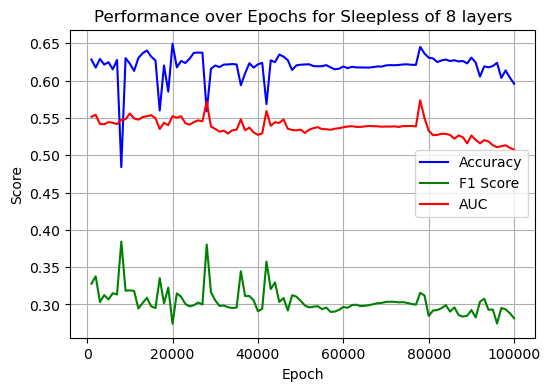

Epoch [10000/100000], Loss: 0.1346, Accuracy: 0.6188, Precision: 0.2688, Recall: 0.3261, F1 Score: 0.2947, AUC: 0.5198
Epoch [20000/100000], Loss: 0.0878, Accuracy: 0.6208, Precision: 0.2731, Recall: 0.3326, F1 Score: 0.2999, AUC: 0.5449
Epoch [30000/100000], Loss: 0.1534, Accuracy: 0.6218, Precision: 0.2636, Recall: 0.3058, F1 Score: 0.2831, AUC: 0.5242
Epoch [40000/100000], Loss: 0.0098, Accuracy: 0.6280, Precision: 0.2668, Recall: 0.2993, F1 Score: 0.2821, AUC: 0.5271
Epoch [50000/100000], Loss: 0.3933, Accuracy: 0.5702, Precision: 0.2728, Recall: 0.4565, F1 Score: 0.3416, AUC: 0.5386
Epoch [60000/100000], Loss: 0.0296, Accuracy: 0.6202, Precision: 0.2758, Recall: 0.3413, F1 Score: 0.3051, AUC: 0.5384
Epoch [70000/100000], Loss: 0.0698, Accuracy: 0.6096, Precision: 0.2579, Recall: 0.3188, F1 Score: 0.2852, AUC: 0.5187
Epoch [80000/100000], Loss: 0.0230, Accuracy: 0.6063, Precision: 0.2606, Recall: 0.3333, F1 Score: 0.2925, AUC: 0.5294
Epoch [90000/100000], Loss: 0.0313, Accuracy: 0.

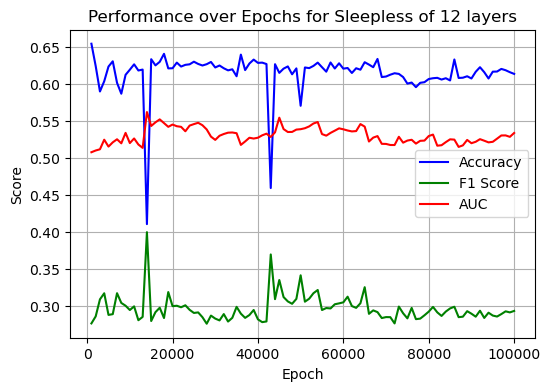

Epoch [10000/100000], Loss: 0.0601, Accuracy: 0.6128, Precision: 0.2648, Recall: 0.3297, F1 Score: 0.2937, AUC: 0.5041
Epoch [20000/100000], Loss: 0.0792, Accuracy: 0.6112, Precision: 0.2624, Recall: 0.3268, F1 Score: 0.2911, AUC: 0.5221
Epoch [30000/100000], Loss: 0.3218, Accuracy: 0.6629, Precision: 0.2731, Recall: 0.2290, F1 Score: 0.2491, AUC: 0.5428
Epoch [40000/100000], Loss: 0.1309, Accuracy: 0.6287, Precision: 0.2693, Recall: 0.3036, F1 Score: 0.2854, AUC: 0.5197
Epoch [50000/100000], Loss: 0.0190, Accuracy: 0.6022, Precision: 0.2667, Recall: 0.3594, F1 Score: 0.3062, AUC: 0.5363
Epoch [60000/100000], Loss: 0.0843, Accuracy: 0.6116, Precision: 0.2772, Recall: 0.3674, F1 Score: 0.3160, AUC: 0.5337
Epoch [70000/100000], Loss: 0.0028, Accuracy: 0.6070, Precision: 0.2698, Recall: 0.3572, F1 Score: 0.3075, AUC: 0.5337
Epoch [80000/100000], Loss: 0.0061, Accuracy: 0.6142, Precision: 0.2717, Recall: 0.3449, F1 Score: 0.3040, AUC: 0.5294
Epoch [90000/100000], Loss: 0.0000, Accuracy: 0.

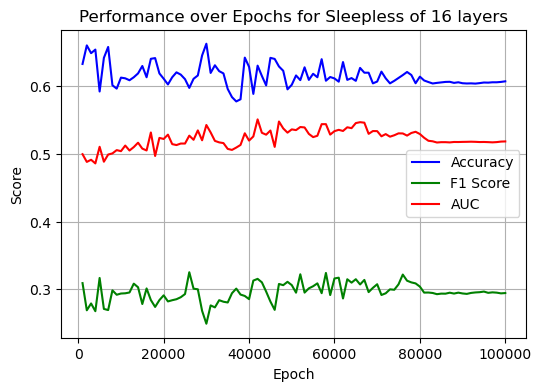

Epoch [10000/100000], Loss: 0.1157, Accuracy: 0.6409, Precision: 0.2968, Recall: 0.3435, F1 Score: 0.3184, AUC: 0.5508
Epoch [20000/100000], Loss: 0.0006, Accuracy: 0.6169, Precision: 0.2840, Recall: 0.3739, F1 Score: 0.3228, AUC: 0.5498
Epoch [30000/100000], Loss: 0.1188, Accuracy: 0.6034, Precision: 0.2726, Recall: 0.3739, F1 Score: 0.3153, AUC: 0.5354
Epoch [40000/100000], Loss: 0.0439, Accuracy: 0.5974, Precision: 0.2727, Recall: 0.3891, F1 Score: 0.3207, AUC: 0.5371
Epoch [50000/100000], Loss: 0.1160, Accuracy: 0.5873, Precision: 0.2648, Recall: 0.3884, F1 Score: 0.3149, AUC: 0.5335
Epoch [60000/100000], Loss: 0.0940, Accuracy: 0.6013, Precision: 0.2697, Recall: 0.3703, F1 Score: 0.3121, AUC: 0.5181
Epoch [70000/100000], Loss: 0.0144, Accuracy: 0.5942, Precision: 0.2719, Recall: 0.3942, F1 Score: 0.3218, AUC: 0.5369
Epoch [80000/100000], Loss: 0.0403, Accuracy: 0.5803, Precision: 0.2618, Recall: 0.3949, F1 Score: 0.3148, AUC: 0.5289
Epoch [90000/100000], Loss: 0.1475, Accuracy: 0.

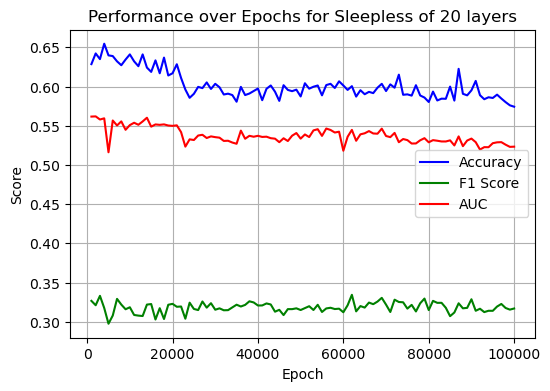


Symptom type: Headache

Epoch [10000/100000], Loss: 0.1960, Accuracy: 0.6098, Precision: 0.2919, Recall: 0.3167, F1 Score: 0.3038, AUC: 0.5356
Epoch [20000/100000], Loss: 0.0651, Accuracy: 0.6024, Precision: 0.2915, Recall: 0.3351, F1 Score: 0.3118, AUC: 0.5355
Epoch [30000/100000], Loss: 0.5705, Accuracy: 0.6118, Precision: 0.2946, Recall: 0.3186, F1 Score: 0.3061, AUC: 0.5478
Epoch [40000/100000], Loss: 0.0505, Accuracy: 0.6167, Precision: 0.2977, Recall: 0.3134, F1 Score: 0.3053, AUC: 0.5297
Epoch [50000/100000], Loss: 0.0288, Accuracy: 0.6112, Precision: 0.2975, Recall: 0.3278, F1 Score: 0.3119, AUC: 0.5293
Epoch [60000/100000], Loss: 0.1162, Accuracy: 0.6240, Precision: 0.3170, Recall: 0.3456, F1 Score: 0.3307, AUC: 0.5498
Epoch [70000/100000], Loss: 0.0248, Accuracy: 0.6126, Precision: 0.3084, Recall: 0.3548, F1 Score: 0.3300, AUC: 0.5435
Epoch [80000/100000], Loss: 0.0622, Accuracy: 0.6093, Precision: 0.3017, Recall: 0.3450, F1 Score: 0.3219, AUC: 0.5399
Epoch [90000/100000], L

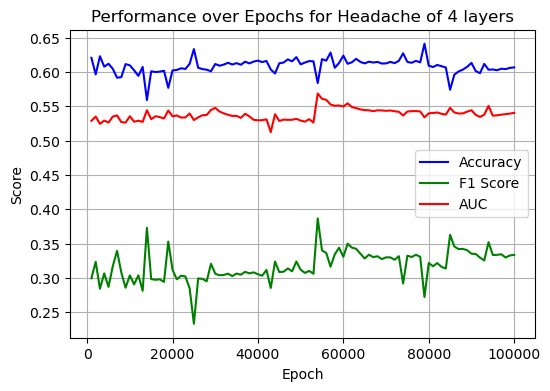

Epoch [10000/100000], Loss: 0.1086, Accuracy: 0.6025, Precision: 0.2947, Recall: 0.3436, F1 Score: 0.3173, AUC: 0.5194
Epoch [20000/100000], Loss: 1.1870, Accuracy: 0.4996, Precision: 0.2998, Recall: 0.6452, F1 Score: 0.4094, AUC: 0.5520
Epoch [30000/100000], Loss: 0.0814, Accuracy: 0.5988, Precision: 0.2897, Recall: 0.3390, F1 Score: 0.3124, AUC: 0.5287
Epoch [40000/100000], Loss: 0.3391, Accuracy: 0.5599, Precision: 0.2828, Recall: 0.4147, F1 Score: 0.3363, AUC: 0.5231
Epoch [50000/100000], Loss: 0.0833, Accuracy: 0.5863, Precision: 0.2871, Recall: 0.3634, F1 Score: 0.3207, AUC: 0.5164
Epoch [60000/100000], Loss: 0.1275, Accuracy: 0.5749, Precision: 0.2833, Recall: 0.3799, F1 Score: 0.3245, AUC: 0.5210
Epoch [70000/100000], Loss: 0.0308, Accuracy: 0.5891, Precision: 0.2793, Recall: 0.3344, F1 Score: 0.3044, AUC: 0.5140
Epoch [80000/100000], Loss: 0.0167, Accuracy: 0.5843, Precision: 0.2720, Recall: 0.3259, F1 Score: 0.2965, AUC: 0.5149
Epoch [90000/100000], Loss: 0.2450, Accuracy: 0.

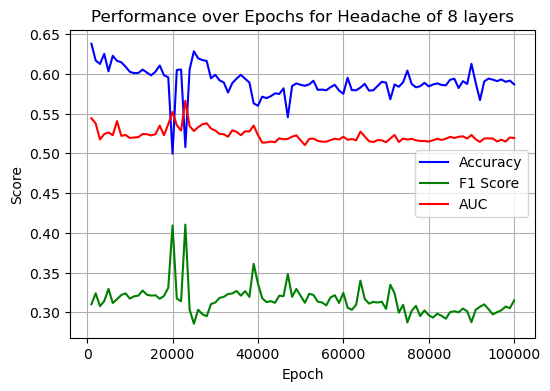

Epoch [10000/100000], Loss: 0.3810, Accuracy: 0.5604, Precision: 0.2985, Recall: 0.4707, F1 Score: 0.3654, AUC: 0.5514
Epoch [20000/100000], Loss: 0.2434, Accuracy: 0.5932, Precision: 0.2943, Recall: 0.3673, F1 Score: 0.3268, AUC: 0.5497
Epoch [30000/100000], Loss: 0.1092, Accuracy: 0.5558, Precision: 0.2896, Recall: 0.4490, F1 Score: 0.3521, AUC: 0.5373
Epoch [40000/100000], Loss: 0.0510, Accuracy: 0.5633, Precision: 0.2932, Recall: 0.4431, F1 Score: 0.3529, AUC: 0.5413
Epoch [50000/100000], Loss: 0.2647, Accuracy: 0.5594, Precision: 0.2910, Recall: 0.4450, F1 Score: 0.3519, AUC: 0.5382
Epoch [60000/100000], Loss: 0.0672, Accuracy: 0.5640, Precision: 0.2916, Recall: 0.4352, F1 Score: 0.3492, AUC: 0.5376
Epoch [70000/100000], Loss: 0.0197, Accuracy: 0.5695, Precision: 0.2958, Recall: 0.4358, F1 Score: 0.3524, AUC: 0.5423
Epoch [80000/100000], Loss: 1.0278, Accuracy: 0.5266, Precision: 0.2916, Recall: 0.5326, F1 Score: 0.3769, AUC: 0.5391
Epoch [90000/100000], Loss: 0.0000, Accuracy: 0.

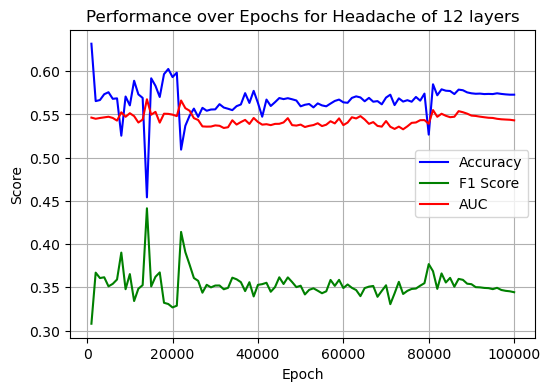

Epoch [10000/100000], Loss: 0.6098, Accuracy: 0.4385, Precision: 0.2933, Recall: 0.7722, F1 Score: 0.4251, AUC: 0.5515
Epoch [20000/100000], Loss: 0.0498, Accuracy: 0.6075, Precision: 0.3029, Recall: 0.3535, F1 Score: 0.3262, AUC: 0.5318
Epoch [30000/100000], Loss: 0.0000, Accuracy: 0.6048, Precision: 0.2936, Recall: 0.3344, F1 Score: 0.3127, AUC: 0.5260
Epoch [40000/100000], Loss: 0.0000, Accuracy: 0.6082, Precision: 0.2967, Recall: 0.3338, F1 Score: 0.3141, AUC: 0.5313
Epoch [50000/100000], Loss: 0.0000, Accuracy: 0.6102, Precision: 0.2972, Recall: 0.3298, F1 Score: 0.3126, AUC: 0.5315
Epoch [60000/100000], Loss: 0.0691, Accuracy: 0.5557, Precision: 0.2914, Recall: 0.4562, F1 Score: 0.3557, AUC: 0.5323
Epoch [70000/100000], Loss: 0.0306, Accuracy: 0.5535, Precision: 0.2864, Recall: 0.4431, F1 Score: 0.3479, AUC: 0.5295
Epoch [80000/100000], Loss: 0.0052, Accuracy: 0.5535, Precision: 0.2842, Recall: 0.4352, F1 Score: 0.3438, AUC: 0.5280
Epoch [90000/100000], Loss: 0.0567, Accuracy: 0.

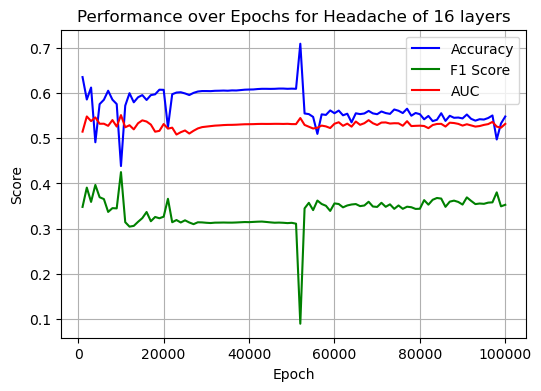

Epoch [10000/100000], Loss: 0.0279, Accuracy: 0.5833, Precision: 0.2827, Recall: 0.3581, F1 Score: 0.3160, AUC: 0.5094
Epoch [20000/100000], Loss: 0.0000, Accuracy: 0.5818, Precision: 0.2795, Recall: 0.3522, F1 Score: 0.3117, AUC: 0.4993
Epoch [30000/100000], Loss: 0.0000, Accuracy: 0.5834, Precision: 0.2806, Recall: 0.3515, F1 Score: 0.3121, AUC: 0.5009
Epoch [40000/100000], Loss: 0.0000, Accuracy: 0.5845, Precision: 0.2773, Recall: 0.3397, F1 Score: 0.3053, AUC: 0.5034
Epoch [50000/100000], Loss: 0.2545, Accuracy: 0.5746, Precision: 0.2929, Recall: 0.4121, F1 Score: 0.3425, AUC: 0.5324
Epoch [60000/100000], Loss: 0.1048, Accuracy: 0.5620, Precision: 0.2904, Recall: 0.4358, F1 Score: 0.3485, AUC: 0.5380
Epoch [70000/100000], Loss: 0.0693, Accuracy: 0.5542, Precision: 0.2883, Recall: 0.4483, F1 Score: 0.3509, AUC: 0.5334
Epoch [80000/100000], Loss: 0.0752, Accuracy: 0.5567, Precision: 0.2913, Recall: 0.4529, F1 Score: 0.3545, AUC: 0.5374
Epoch [90000/100000], Loss: 0.0441, Accuracy: 0.

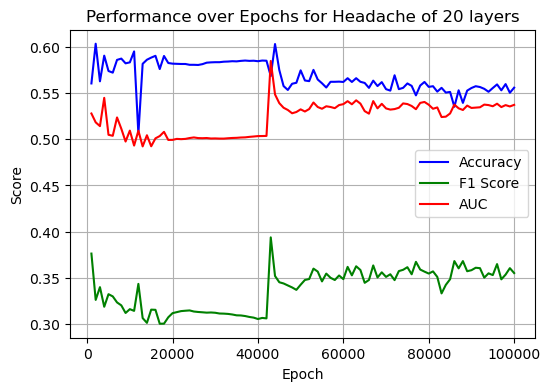


Symptom type: Urination

Epoch [10000/100000], Loss: 0.0981, Accuracy: 0.6362, Precision: 0.2500, Recall: 0.2812, F1 Score: 0.2647, AUC: 0.5259
Epoch [20000/100000], Loss: 0.0577, Accuracy: 0.6392, Precision: 0.2529, Recall: 0.2812, F1 Score: 0.2663, AUC: 0.5237
Epoch [30000/100000], Loss: 0.0335, Accuracy: 0.6317, Precision: 0.2414, Recall: 0.2713, F1 Score: 0.2555, AUC: 0.5258
Epoch [40000/100000], Loss: 0.0788, Accuracy: 0.6319, Precision: 0.2474, Recall: 0.2842, F1 Score: 0.2645, AUC: 0.5250
Epoch [50000/100000], Loss: 0.0295, Accuracy: 0.6401, Precision: 0.2500, Recall: 0.2728, F1 Score: 0.2609, AUC: 0.5249
Epoch [60000/100000], Loss: 0.2506, Accuracy: 0.5939, Precision: 0.2476, Recall: 0.3647, F1 Score: 0.2949, AUC: 0.5153
Epoch [70000/100000], Loss: 0.5661, Accuracy: 0.5491, Precision: 0.2498, Recall: 0.4673, F1 Score: 0.3256, AUC: 0.5307
Epoch [80000/100000], Loss: 0.6610, Accuracy: 0.4564, Precision: 0.2349, Recall: 0.5912, F1 Score: 0.3362, AUC: 0.5063
Epoch [90000/100000], 

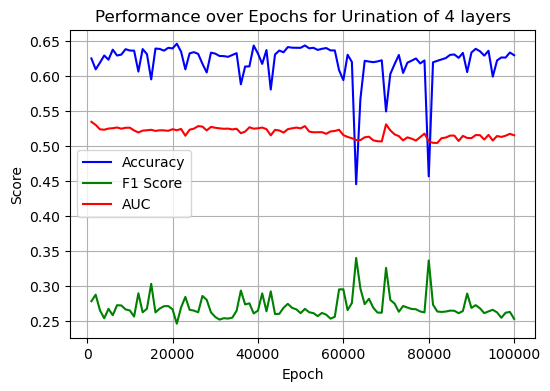

Epoch [10000/100000], Loss: 0.0915, Accuracy: 0.6257, Precision: 0.2489, Recall: 0.3009, F1 Score: 0.2724, AUC: 0.5182
Epoch [20000/100000], Loss: 0.0714, Accuracy: 0.6174, Precision: 0.2521, Recall: 0.3267, F1 Score: 0.2846, AUC: 0.5230
Epoch [30000/100000], Loss: 0.2128, Accuracy: 0.5960, Precision: 0.2438, Recall: 0.3495, F1 Score: 0.2872, AUC: 0.5157
Epoch [40000/100000], Loss: 0.0650, Accuracy: 0.6020, Precision: 0.2336, Recall: 0.3108, F1 Score: 0.2667, AUC: 0.5140
Epoch [50000/100000], Loss: 0.2982, Accuracy: 0.6245, Precision: 0.2552, Recall: 0.3191, F1 Score: 0.2836, AUC: 0.5144
Epoch [60000/100000], Loss: 0.0784, Accuracy: 0.6233, Precision: 0.2523, Recall: 0.3146, F1 Score: 0.2800, AUC: 0.5197
Epoch [70000/100000], Loss: 0.0980, Accuracy: 0.6167, Precision: 0.2479, Recall: 0.3176, F1 Score: 0.2785, AUC: 0.5151
Epoch [80000/100000], Loss: 0.1122, Accuracy: 0.6146, Precision: 0.2497, Recall: 0.3267, F1 Score: 0.2831, AUC: 0.5078
Epoch [90000/100000], Loss: 0.1193, Accuracy: 0.

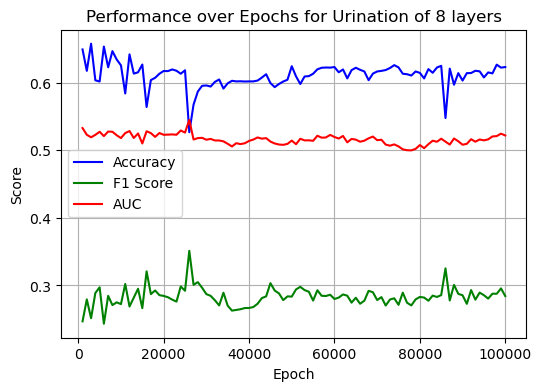

Epoch [10000/100000], Loss: 0.1164, Accuracy: 0.6034, Precision: 0.2507, Recall: 0.3533, F1 Score: 0.2933, AUC: 0.5139
Epoch [20000/100000], Loss: 0.6251, Accuracy: 0.5818, Precision: 0.2548, Recall: 0.4134, F1 Score: 0.3153, AUC: 0.5327
Epoch [30000/100000], Loss: 0.1556, Accuracy: 0.6045, Precision: 0.2598, Recall: 0.3777, F1 Score: 0.3078, AUC: 0.5170


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 데이터 준비
X = df.iloc[:,:-11]
Y = df.iloc[:,-11:]
Y = Y[['Sleepless','Headache','Urination']]
col_names = Y.columns.tolist()

X = X.values
Y = Y.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# SimpleNN 모델 정의
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(SimpleNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 저장 딕셔너리
acc_model_dict = {}
f1_model_dict = {}
auc_model_dict = {}
best_accuracy_dict = {}
best_f1_dict = {}
best_auc_dict = {}

# 에폭에 따른 성능 기록을 위한 딕셔너리

for y_col_idx in range(Y.shape[1]):
    y = Y[:, y_col_idx]
    print(f'\nSymptom type: {col_names[y_col_idx]}\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1111, stratify=y)

    # SMOTE 적용
    smote = SMOTE(random_state=1111, sampling_strategy='auto')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    X_train = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train_resampled, dtype=torch.float32).view(-1, 1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
    
    # 모델 설정
    input_dim = X_train.shape[1]
    hidden_dim = 64
    output_dim = 1
    early_stopping_threshold = 0.60  # 성능이 일정 수준 이하로 떨어지면 멈춤
    
    best_accuracy = 0.0  # 가장 좋은 정확도 초기값
    best_f1 = 0.0  # 가장 좋은 F1 점수 초기값
    best_auc = 0.0  # 가장 좋은 AUC 점수 초기값
    
    for num_layers in [4,8,12,16,20]:
        epoch_performance = {'epoch': [], 'accuracy': [], 'f1': [], 'auc': []}
        model = SimpleNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 훈련
        num_epochs = 100000
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            
            if (epoch + 1) % 1000 == 0:
                with torch.no_grad():
                    model.eval()
                    y_pred = model(X_test)
                    y_pred_class = (y_pred > 0.5).float()
                    accuracy = (y_pred_class == y_test).float().mean().item()
                    precision = precision_score(y_test.cpu(), y_pred_class.cpu())
                    recall = recall_score(y_test.cpu(), y_pred_class.cpu())
                    f1 = f1_score(y_test.cpu(), y_pred_class.cpu())
                    auc = roc_auc_score(y_test.cpu(), y_pred.cpu())
                    
                    # 성능 기록
                    epoch_performance['epoch'].append(epoch + 1)
                    epoch_performance['accuracy'].append(accuracy)
                    epoch_performance['f1'].append(f1)
                    epoch_performance['auc'].append(auc)

                    if (epoch + 1) % 10000 == 0:
                        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}')
                    
        
        # 최종 평가 및 모델 저장
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            y_pred_class = (y_pred > 0.5).float()
            accuracy = (y_pred_class == y_test).float().mean().item()
            precision = precision_score(y_test.cpu(), y_pred_class.cpu())
            recall = recall_score(y_test.cpu(), y_pred_class.cpu())
            f1 = f1_score(y_test.cpu(), y_pred_class.cpu())
            auc = roc_auc_score(y_test.cpu(), y_pred.cpu())
            cm = confusion_matrix(y_test.cpu(), y_pred_class.cpu())
            print(f'\nLayers: {num_layers}, Final Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}')
            # print_confusion_matrix(cm, class_names)  # Custom function for confusion matrix
            
            # 성능이 더 좋은 경우에만 모델을 저장
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                acc_model_dict[f'model_{col_names[y_col_idx]}'] = model
                best_accuracy_dict[f'model_{col_names[y_col_idx]}'] = best_accuracy
                print(f'New best model for {col_names[y_col_idx]} with Accuracy Score {best_accuracy:.4f}')
            if f1 > best_f1:
                best_f1 = f1
                f1_model_dict[f'model_{col_names[y_col_idx]}'] = model
                best_f1_dict[f'model_{col_names[y_col_idx]}'] = best_f1
                print(f'New best model for {col_names[y_col_idx]} with F1 Score {best_f1:.4f}')
            if auc > best_auc:
                best_auc = auc
                auc_model_dict[f'model_{col_names[y_col_idx]}'] = model
                best_auc_dict[f'model_{col_names[y_col_idx]}'] = best_auc
                print(f'New best model for {col_names[y_col_idx]} with AUC Score {best_auc:.4f}')
                
        # 에폭에 따른 성능 시각화
        df_performance = epoch_performance
        
        plt.figure(figsize=(6, 4))
        plt.plot(df_performance['epoch'], df_performance['accuracy'], label='Accuracy', color='blue')
        plt.plot(df_performance['epoch'], df_performance['f1'], label='F1 Score', color='green')
        plt.plot(df_performance['epoch'], df_performance['auc'], label='AUC', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title(f'Performance over Epochs for {col_names[y_col_idx]} of {num_layers} layers')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{BF.path}\\불편증상 분류모델\\Performance over Epochs for {col_names[y_col_idx]} of {num_layers} layers.png')
        plt.show()


In [50]:
Y[['Sleepless','Headache','Urination']]

,Sleepless,Headache,Urination
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
28246,0,0,0
28247,0,0,0
28248,0,0,0
28249,0,0,0


In [59]:
best_f1_dict

{'model_Sleepless': 0.28758169934640526,
 'model_Headache': 0.29687499999999994,
 'model_Urination': 0.24607520993063162}